In [31]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, LeaveOneOut, cross_validate, cross_val_score
)
from sklearn.linear_model import (
    LinearRegression, Lasso, LassoCV, MultiTaskLasso, MultiTaskLassoCV,
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance


# Statistic imports 
from scipy.stats import ks_2samp
from scipy.special import kl_div
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

# Specialized imputation and visualization packages
import miceforest as mf
import missingno as msno
#from missforest import MissForest
#import magic
from src.gain import *

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


## Load data 

In [32]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features = data["df_select_features"]
df_select_features.columns = ["RNA", "CSF", "DNA", "MRIth"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

# Train best model

## Train TabNetRegressor

In [33]:
n_features = 20

In [34]:
if True: 

    idx_train = list(df_X.isna().any(axis=1))
    idx_test = list(~df_X.isna().any(axis=1))

    set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
    intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

    for i, bool_test in enumerate(idx_test): 
        if intersect_rid_idx.iloc[i] & bool_test:
            idx_test[i] = False
            idx_train[i] = True

    df_X_train = df_X.loc[idx_train]
    df_X_test = df_X.loc[idx_test]

    df_y_train = df_y.loc[idx_train]
    df_y_test = df_y.loc[idx_test]

    c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
    c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

    continuous_model  = imputer = KNNImputer(n_neighbors=5)
    name_continuous_imputer  = "KNNImputer_5"
    ordinal_model =  KNNImputer(n_neighbors=1)
    name_ordinal_imputer = "KNNImputer"
    tabnet_model =  TabNetModelWrapper(n_a=8, n_d=8)#   XGBoostRegressor() #  TabNetModelWrapper(n_a=8, n_d=8)
    name_model = "TabNetRegressor" # "XGBoostRegressor"#  "TabNetRegressor"

    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Separate imputers for ordinal and continuous data
    print("Using separate imputers for ordinal and continuous data.")

    df_X_train = df_X_train.copy()
    df_X_test = df_X_test.copy()

    # Continuous Imputation Transformer (Example: SimpleImputer)
    continuous_imputer = Pipeline([
        (name_continuous_imputer, continuous_model),
    ])

    # Ordinal Imputation Transformer (Example: KNN Imputer)
    ordinal_imputer = Pipeline([
        (name_ordinal_imputer, ordinal_model)
    ])

    # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_imputer, ordinal_features),
            ('continuous', continuous_imputer, continuous_features)
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

        # Separate imputers for ordinal and continuous data

    # Fit and transform, then convert back to DataFrame with original column names
    start = time.time()
    pipeline.fit(df_X_train)
    end = time.time()

    impute_model_time = end - start

    X_train_imputed = pipeline.transform(df_X_train)
    df_X_train_imputed = df_X_train.copy()
    df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

    # Transform the test set
    if df_X_test.isna().any().any(): 
        X_test_imputed = pipeline.transform(df_X_test)
        df_X_test_imputed = df_X_test.copy()
        df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
    else : 
        print("No NaN in test data -> Keep as it is. ")
        df_X_test_imputed = df_X_test

    df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("int", errors='ignore')
    df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("int", errors='ignore')

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()

    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)
    
    # Standardize only continuous features
    scaler = StandardScaler()

    X_train_adjusted[continuous_features] = scaler.fit_transform(X_train_adjusted[continuous_features])
    X_test_adjusted[continuous_features] = scaler.transform(X_test_adjusted[continuous_features])

    # Perform prediction and save variables
    start = time.time()
    tabnet_model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = tabnet_model.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }

    def compute_all_metrics(y_test, y_pred): 
        # Metrics computed in adjusted space
        mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
        mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
        r2 = r2_score(y_test,y_pred, multioutput="raw_values")
        explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

        try: 
            corr_p = correlation(y_pred, y_test)
        except: 
            print("Problem when computing correlation!")
            if type(y_test) != type(y_pred): 
                print("Type of inputs is different.")
                corr_p = None
            else : 
                corr_p = pearsonr(y_test, y_pred)

        return mse_score, mae_score, r2, explained_variance, corr_p

    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }


Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
epoch 0  | loss: 2.53895 |  0:00:00s
epoch 1  | loss: 1.58979 |  0:00:00s
epoch 2  | loss: 1.22013 |  0:00:00s
epoch 3  | loss: 1.00636 |  0:00:00s
epoch 4  | loss: 0.95021 |  0:00:00s
epoch 5  | loss: 0.90679 |  0:00:00s
epoch 6  | loss: 0.8647  |  0:00:00s
epoch 7  | loss: 0.83772 |  0:00:00s
epoch 8  | loss: 0.81759 |  0:00:00s
epoch 9  | loss: 0.8123  |  0:00:00s
epoch 10 | loss: 0.80257 |  0:00:00s
epoch 11 | loss: 0.79333 |  0:00:00s
epoch 12 | loss: 0.79088 |  0:00:00s
epoch 13 | loss: 0.771   |  0:00:00s
epoch 14 | loss: 0.76155 |  0:00:00s
epoch 15 | loss: 0.75178 |  0:00:00s
epoch 16 | loss: 0.75811 |  0:00:00s
epoch 17 | loss: 0.74076 |  0:00:00s
epoch 18 | loss: 0.73147 |  0:00:00s
epoch 19 | loss: 0.72248 |  0:00:01s
epoch 20 | loss: 0.71376 |  0:00:01s
epoch 21 | loss: 0.70822 |  0:00:01s
epoch 22 | loss: 0.70477 |  0:00:01s
epoch 23 | loss: 0.70551 |  0:00:01s
epoch 24 | loss:

In [35]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

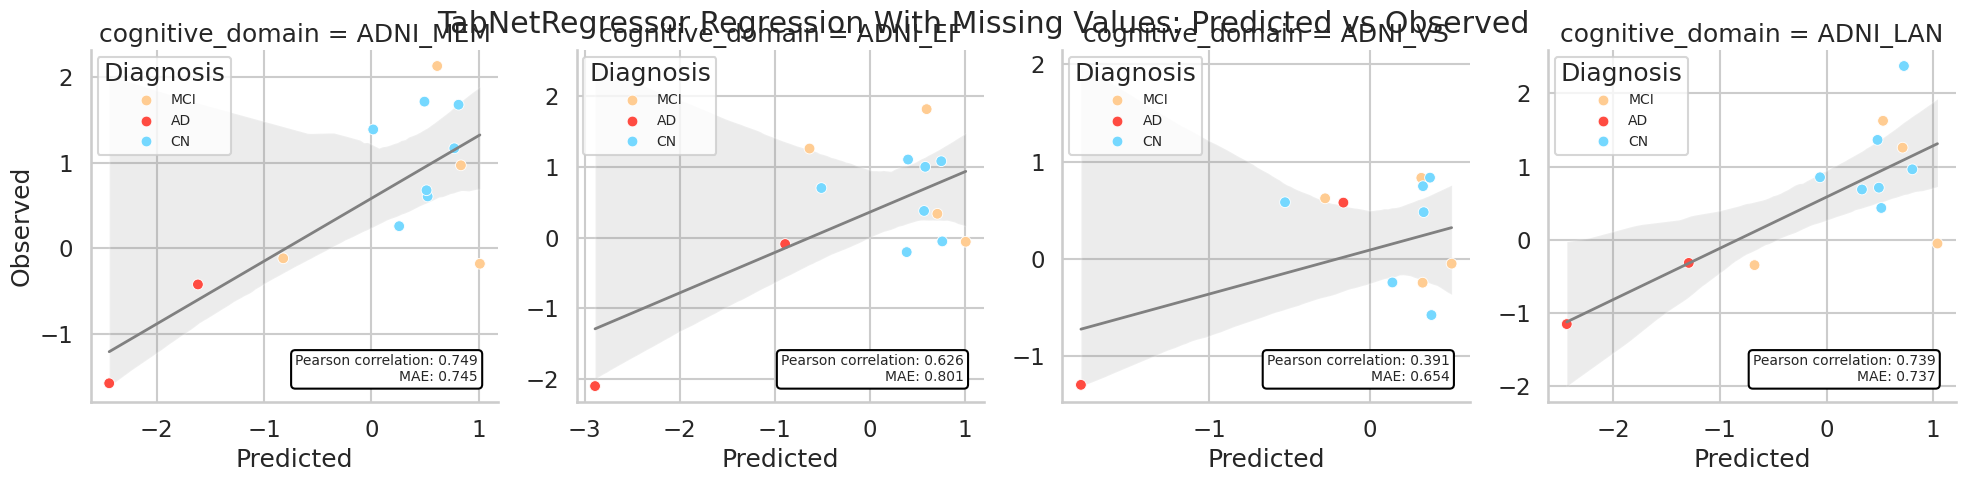

In [36]:
sns.set_style("whitegrid")

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    ax.legend(loc="upper left", title="Diagnosis", fontsize=10)
    
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle(f"{name_model} Regression With Missing Values: Predicted vs Observed")  # Add a title

plt.show()


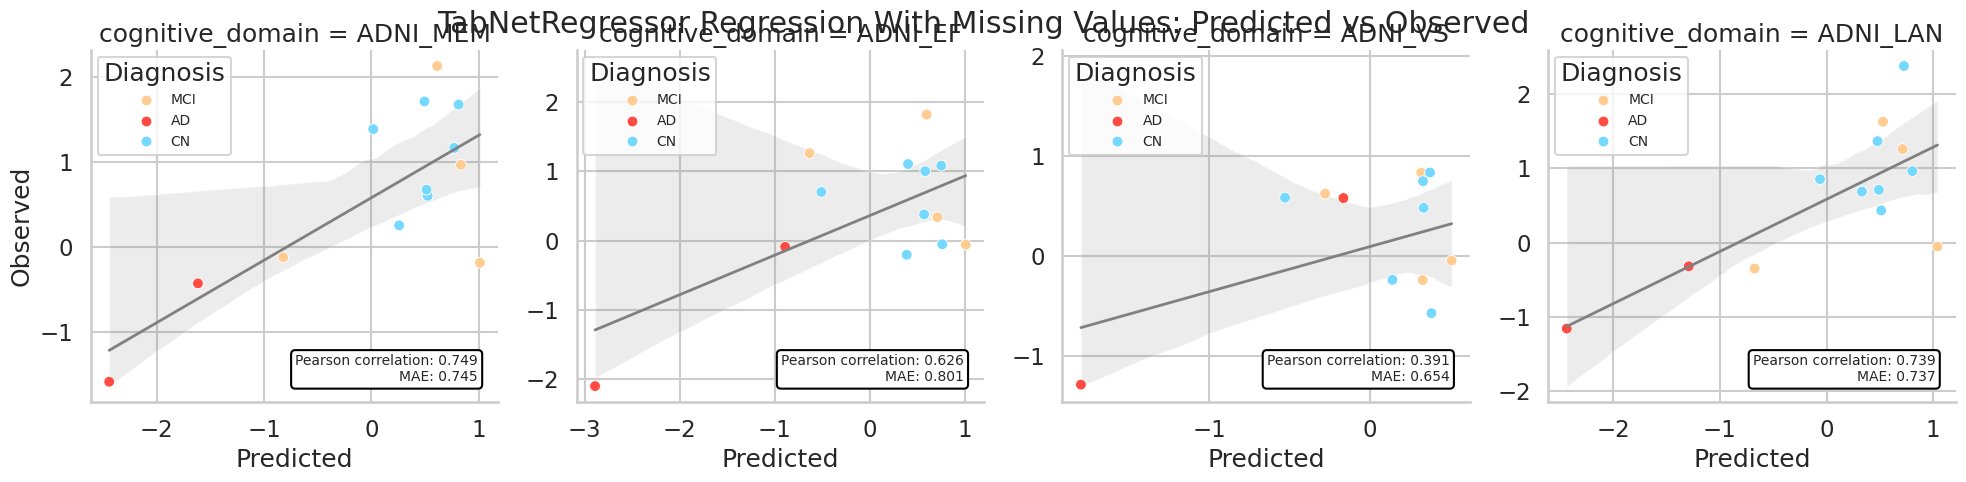

In [37]:
sns.set_style("whitegrid")

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    ax.legend(loc="upper left", title="Diagnosis", fontsize=10)
    
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle(f"{name_model} Regression With Missing Values: Predicted vs Observed")  # Add a title

plt.show()


#### Model specific importance values

In [38]:
category_palette = {'RNA': full_palette["yellow"],
 'MRIth': full_palette["cyan"],
 'CSF': full_palette["blue"],
 'DNA': full_palette["orange"],
 'ADNI_cog': full_palette["green"]
 }
sns.color_palette(category_palette.values())

[(1.0, 0.6666666666666666, 0.2549019607843137),
 (0.8431372549019608, 0.8274509803921568, 0.2549019607843137),
 (0.4588235294117647, 0.8470588235294118, 1.0),
 (1.0, 0.29411764705882354, 0.2549019607843137),
 (0.4392156862745098, 0.8509803921568627, 0.2549019607843137)]

In [39]:
# Function to clean up y-tick labels
def clean_ytick_label(label):
    label = label.replace("_epsilon", "").replace("_Cortical", "")
    label = label.replace("LH", "Left").replace("RH", "Right")
    label = label.replace("LH", "Left").replace("RH", "Right")
    label = label.replace("LH", "Left").replace("RH", "Right")
    label = label.replace("_", " ")  # Remove remaining underscores
    if len(label.split(" || ")) > 1: 
        label = label.split(" || ")[1]
    
    return label

In [40]:
n_features = 20

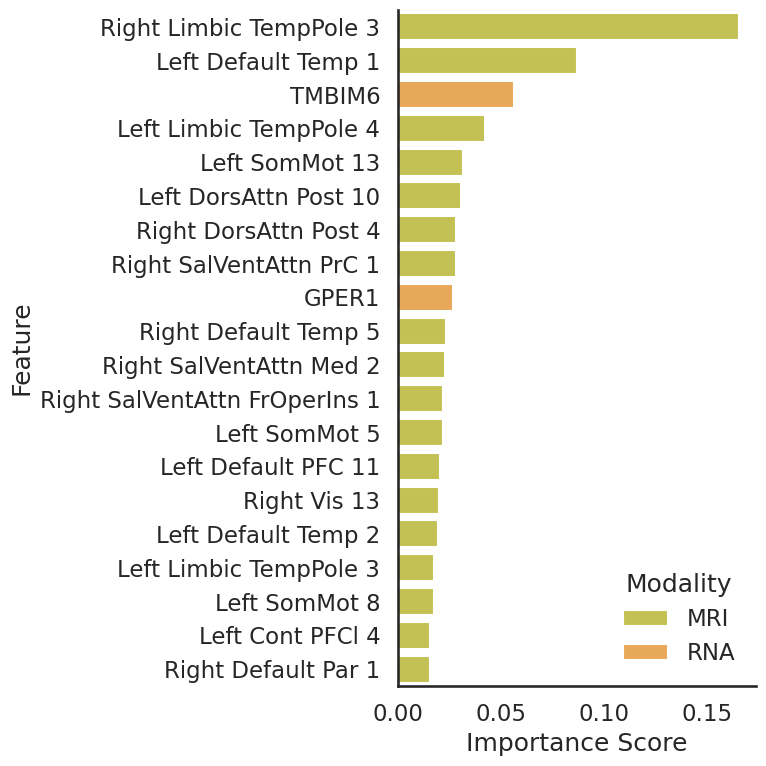

In [41]:
# Extract feature importances
feature_importances = tabnet_model.model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top N features
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Add a 'Category' column based on the 'select' dictionary
top_features_df['Modality'] = top_features_df['Feature'].map(
    lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
)

sns.set_style("white")
sns.set_context("talk")
#sns.set(font="Helvetica")

# Plot the barplot with category-based coloring
plt.figure(figsize=(8, 8))

ax = sns.barplot(
    data=top_features_df,
    x="Importance",
    y="Feature",
    hue="Modality", 
    palette=category_palette
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")

# Apply changes to y-tick labels for each subplot
#for ax in g.axes.flat:
# Get current y-tick labels
ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]

# Update y-tick labels
new_labels = [clean_ytick_label(label) for label in ytick_labels]
ax.set_yticklabels(new_labels)

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Replace "MRIth" with "MRI" in the labels
updated_labels = [label.replace("MRIth", "MRI") for label in labels]

# Set the updated legend
ax.legend(handles, updated_labels, title="Modality", loc="best", frameon=False)

sns.despine()

plt.tight_layout()
plt.show()


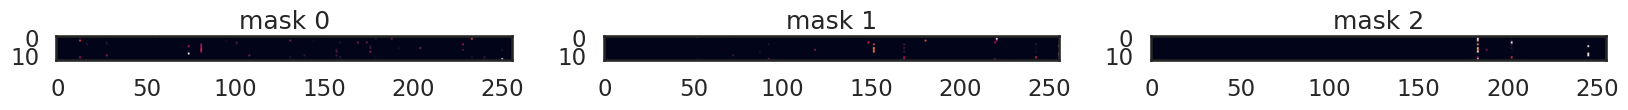

In [42]:
explain_matrix, masks = tabnet_model.model.explain(X_test_adjusted.values)

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

<Figure size 640x480 with 0 Axes>

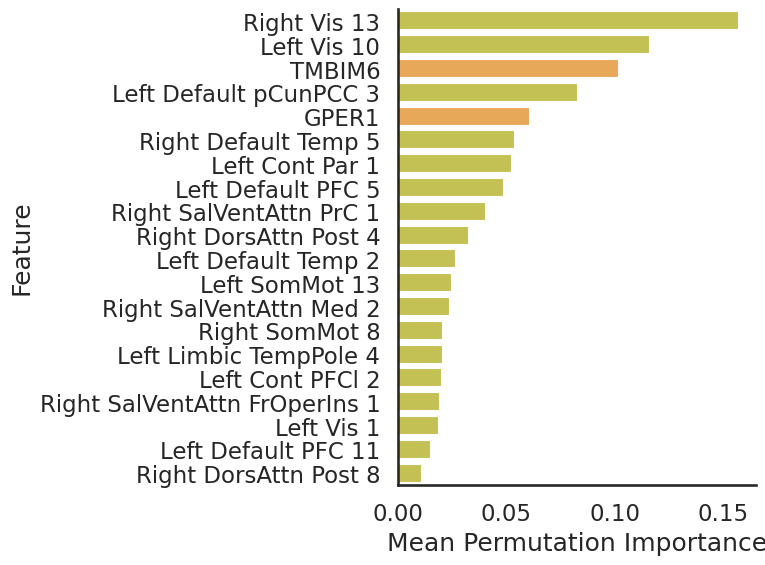

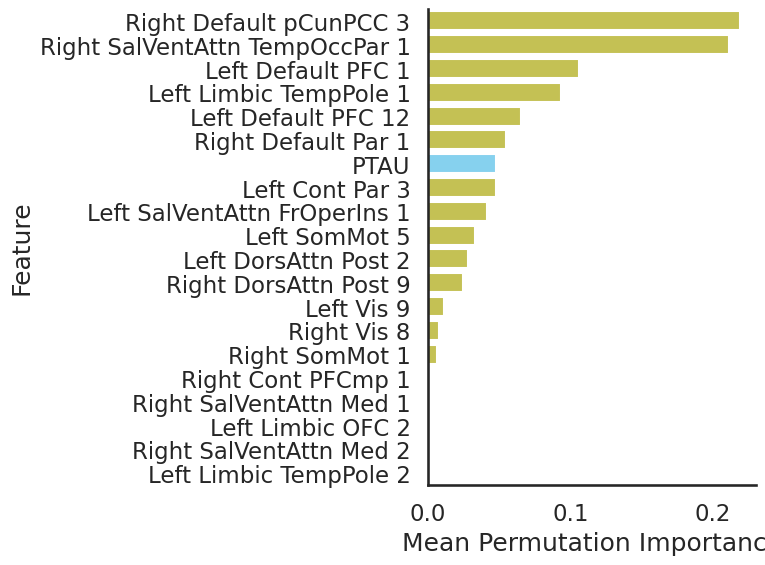

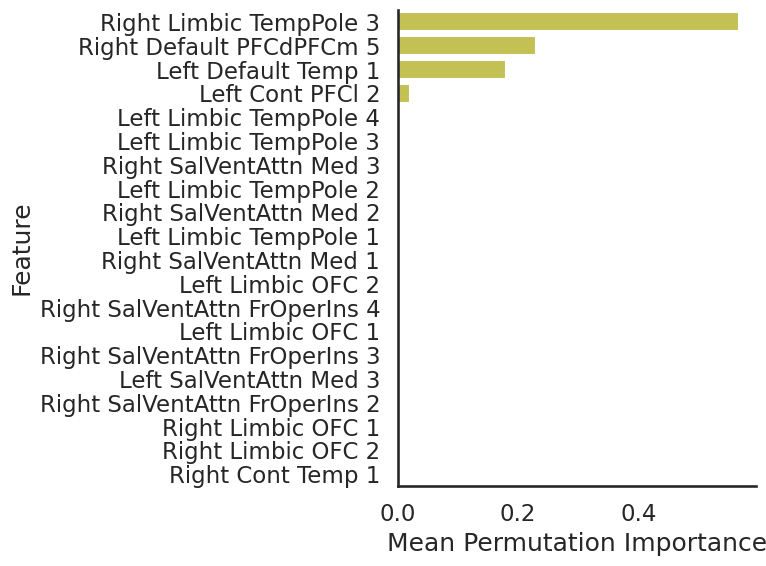

In [43]:
for item in masks.values(): 

    sns.despine()
    plt.tight_layout()
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    
    # Select the top n features for the current target
    importances = pd.DataFrame({"Feature": df_X.columns.tolist(), "Importance": item.mean(0)})
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
    )

    importances.sort_values("Importance", ascending=False)
    
    # Create the barplot
    ax = sns.barplot(
        x="Importance", y="Feature", data=importances.sort_values("Importance", ascending=False).head(20),
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)

    ax.set_xlabel("Mean Permutation Importance", fontsize=18)
    ax.set_ylabel("Feature", fontsize=18)
    
    # Remove legend from each individual plot
    ax.legend().set_visible(False)
    
    sns.despine()
    plt.tight_layout()


#### Permutation importance values

In [44]:
from sklearn.metrics import mean_absolute_error, make_scorer

# Create a scorer from mean_absolute_error
mae_scorer = make_scorer(mean_absolute_error, multioutput="raw_values", greater_is_better=False)

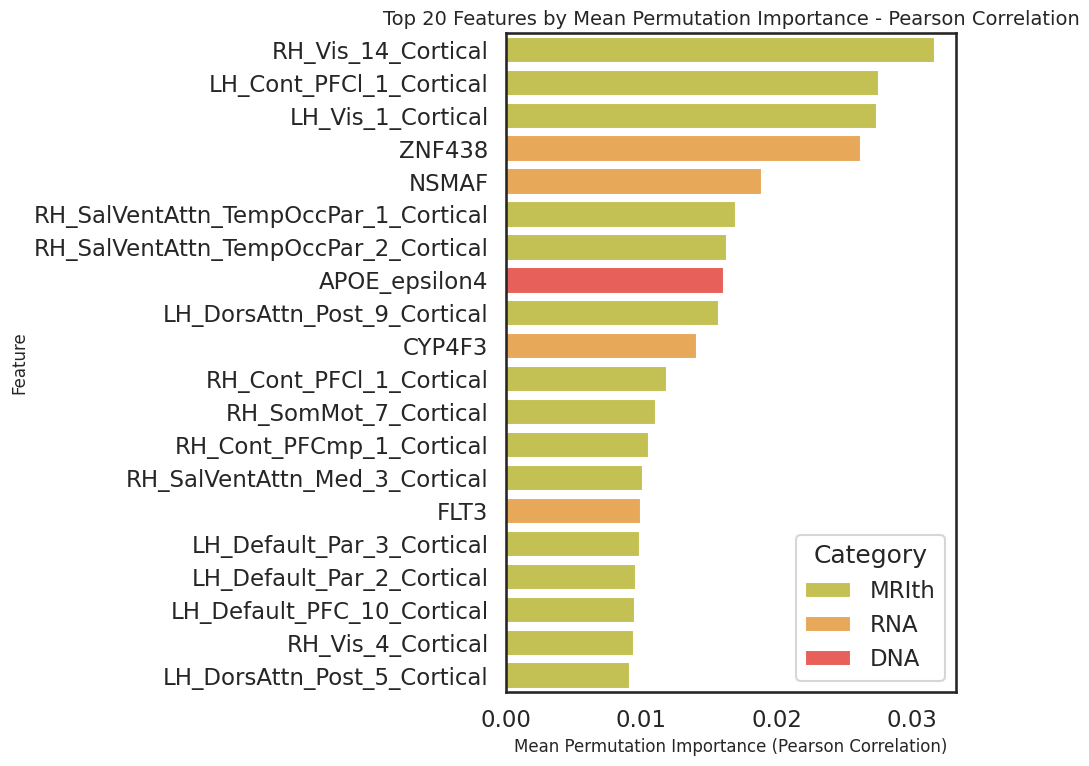

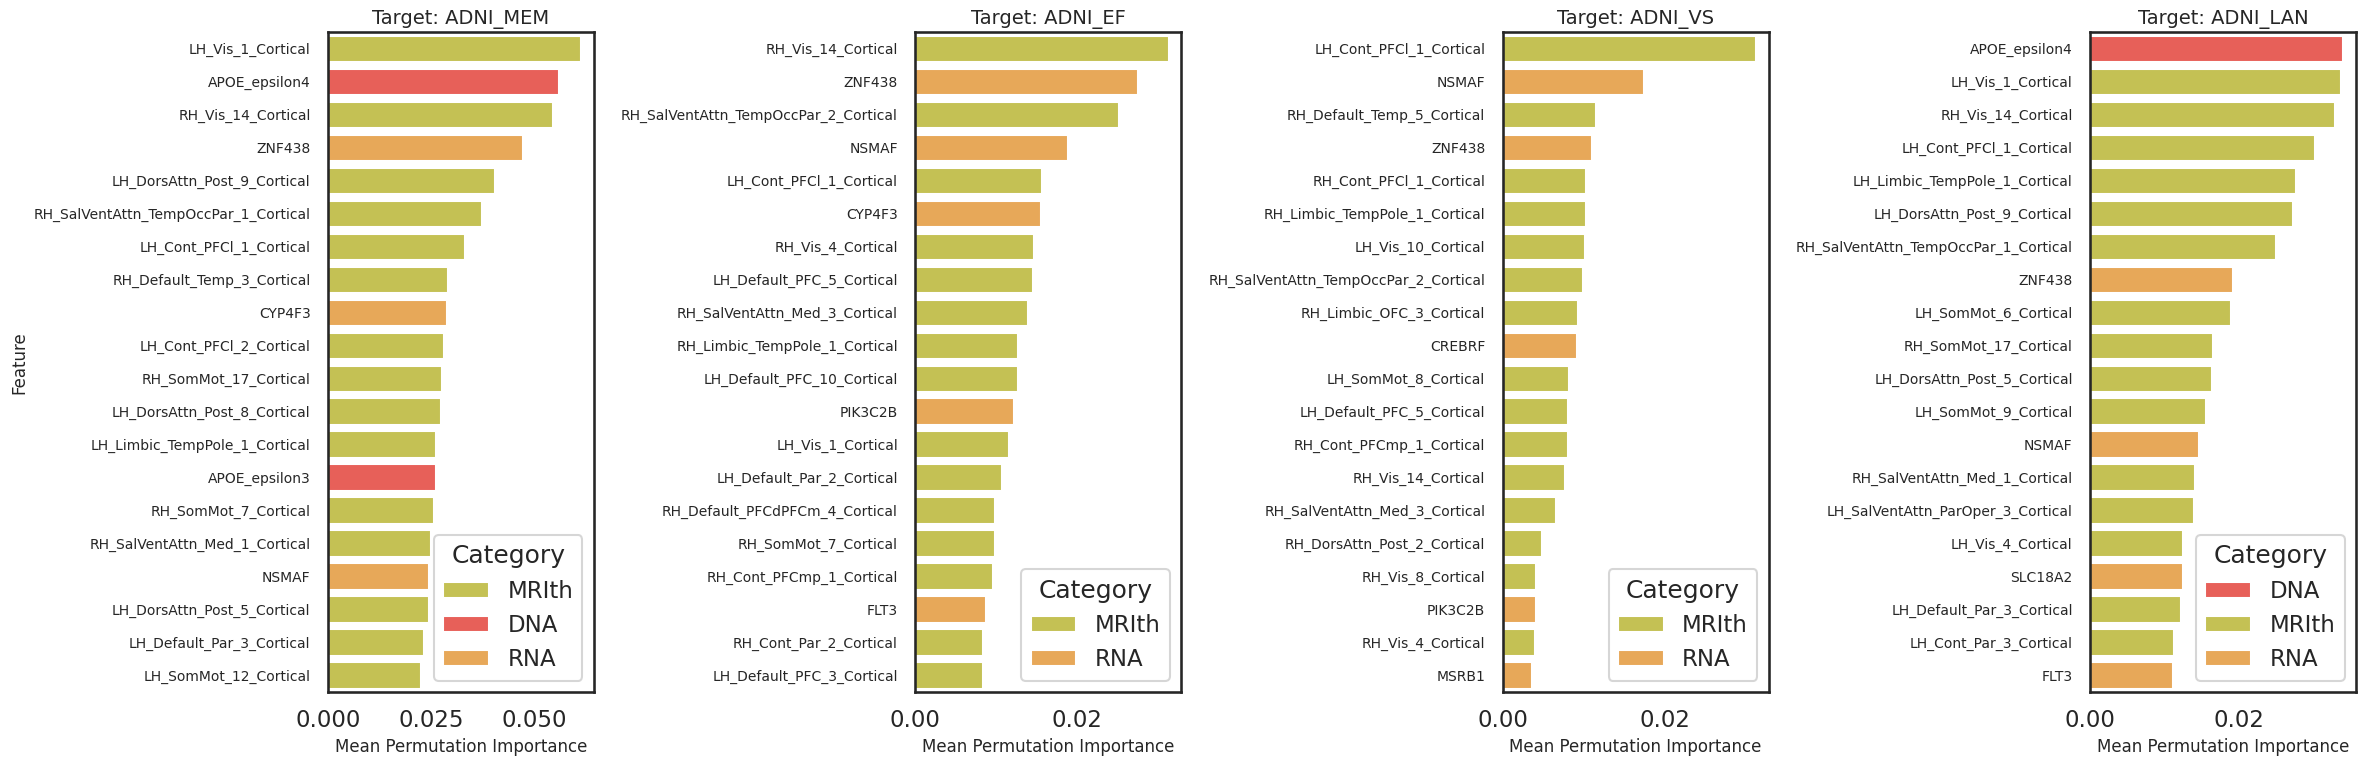

In [45]:
X_test = X_test_adjusted
X_train = X_train_adjusted
Y_test = y_test_adjusted

model = tabnet_model

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=mae_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)

# Add a 'Category' column based on the 'select' dictionary
mean_importance['Category'] = mean_importance['Feature'].map(
    lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
)

# # Step 4: Plot for each target
# for target in permutation_results:
#     plot_importance(
#         permutation_results[target], title=f"Top 40 Features for Target: {target}"
#     )

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance - Pearson Correlation", top_n=n_features, hue="Category", palette=category_palette)

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)

    importances['Category'] = importances['Feature'].map(
    lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette=category_palette, hue="Category", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

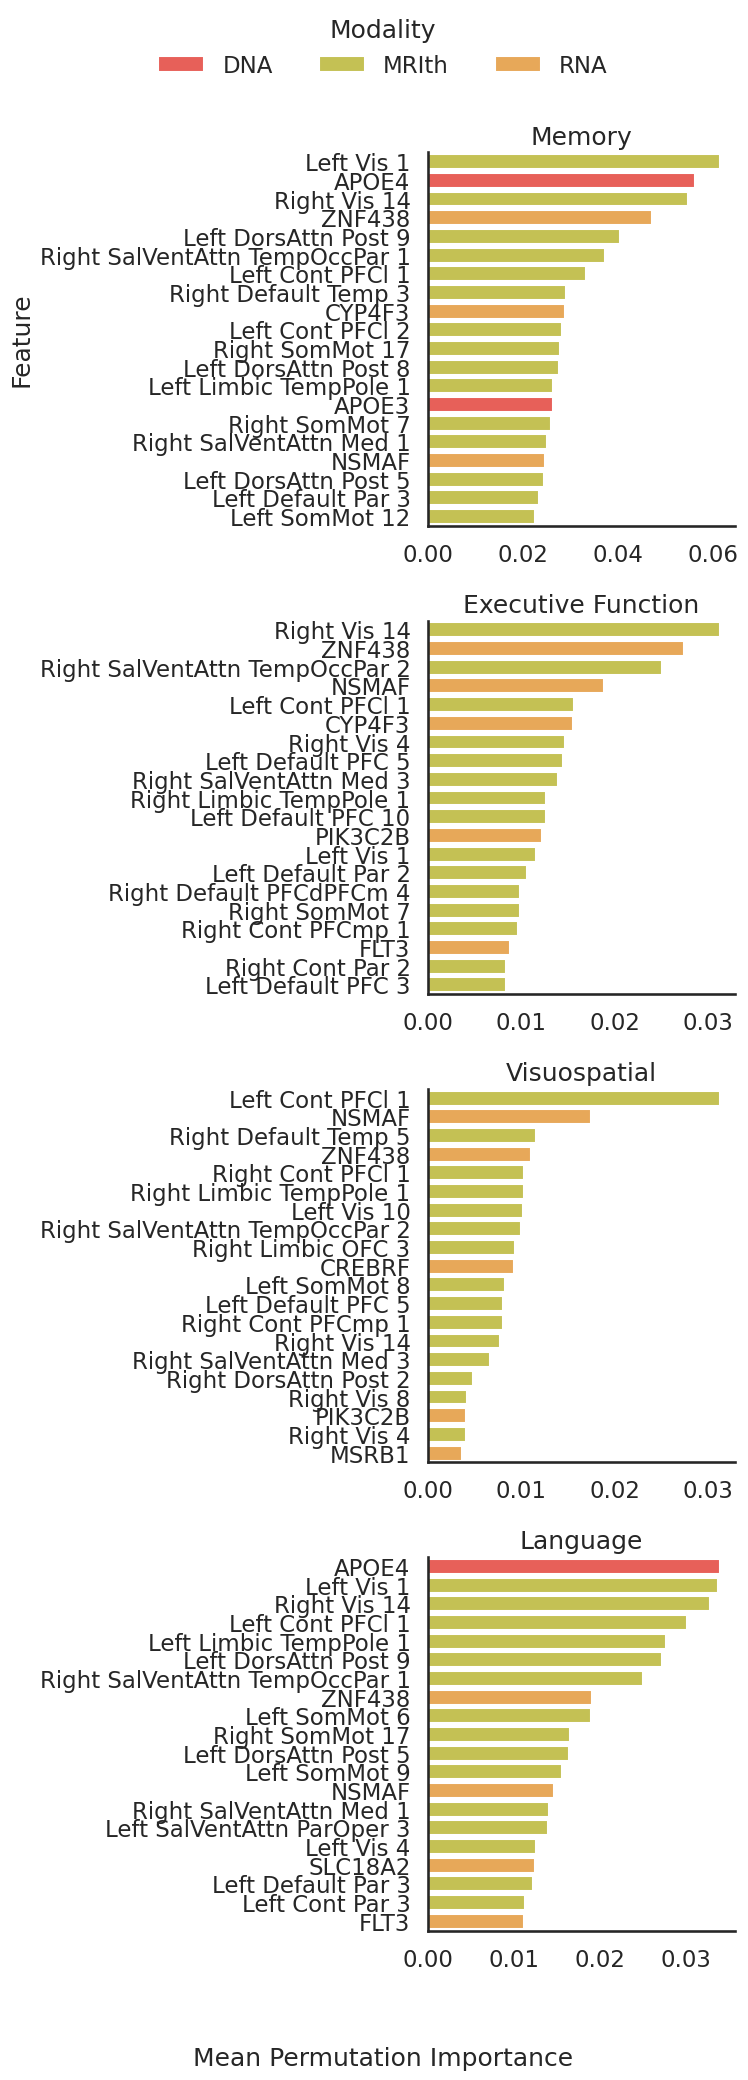

In [46]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(num_targets, 1, figsize=(8, 5 * num_targets), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top n features for the current target
    importances = permutation_results[target].head(n_features)
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
    )
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax,
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)
    
    # Title and labels
    readable_title = readable_names.get(target, target)  # Use readable name or fallback to original
    ax.set_title(readable_title, fontsize=18)
    
    ax.set_xlabel("")  # Remove individual x-labels
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature")
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y')

    ax.legend().set_visible(False)

# Remove duplicate legends and create a single, consistent legend
handles, labels = axes[0].get_legend_handles_labels()
unique_handles_labels = list(zip(handles, labels))
handles, labels = zip(*sorted(unique_handles_labels, key=lambda x: x[1]))  # Sort legend alphabetically

fig.legend(
    handles, labels, title="Modality", loc="upper center", bbox_to_anchor=(0.5, 1.05),
    ncol=3, frameon=False
)

# Add a single x-label in the bottom-middle of the figure
fig.text(0.5, 0.02, "Mean Permutation Importance", ha="center", va="center", fontsize=18)

sns.despine()

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the x-label
plt.show()


<Figure size 640x480 with 0 Axes>

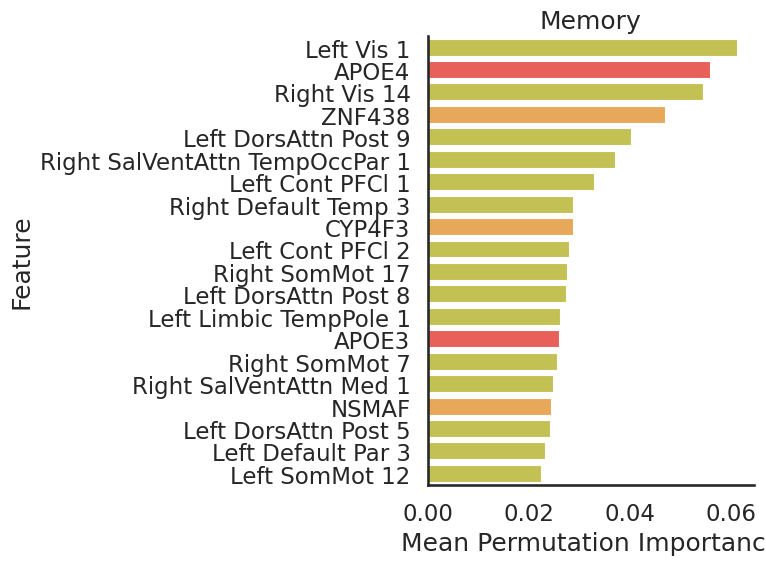

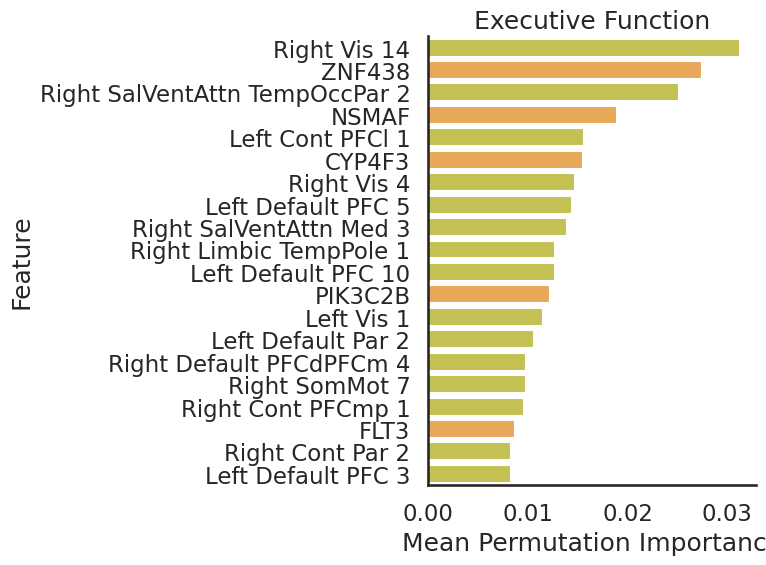

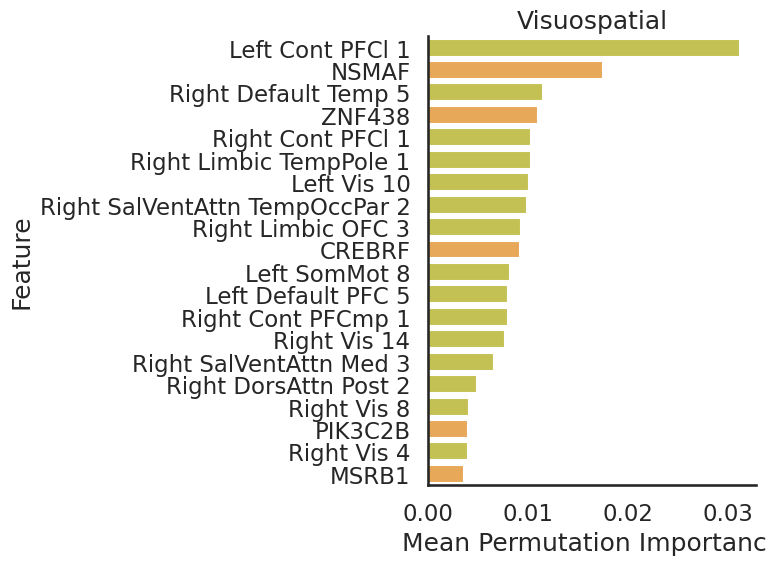

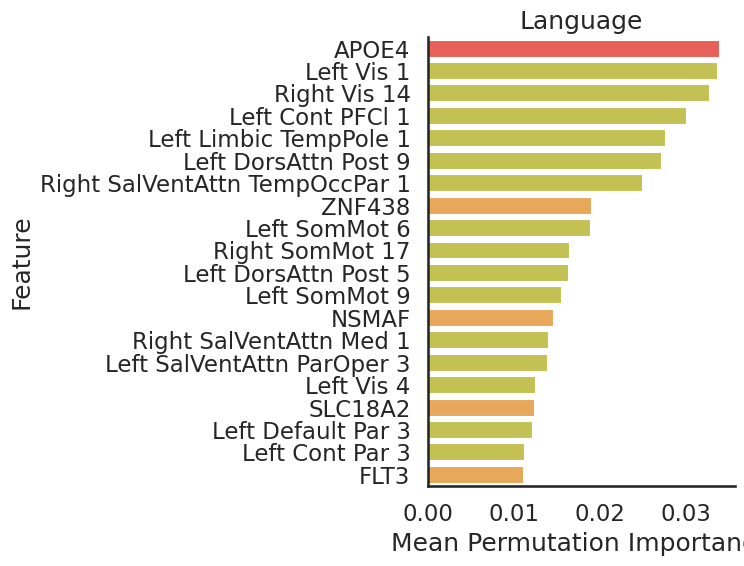

In [47]:
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
}

# Generate individual plots for each target
for target in permutation_results.keys():

    sns.despine()
    plt.tight_layout()
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    
    # Select the top n features for the current target
    importances = permutation_results[target].head(n_features)
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
    )
    
    # Create the barplot
    ax = sns.barplot(
        x="Importance", y="Feature", data=importances,
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)
    
    # Title and labels
    readable_title = readable_names.get(target, target)
    ax.set_title(readable_title, fontsize=18)
    
    ax.set_xlabel("Mean Permutation Importance", fontsize=18)
    ax.set_ylabel("Feature", fontsize=18)
    
    # Remove legend from each individual plot
    ax.legend().set_visible(False)
    
    sns.despine()
    plt.tight_layout()

    plt.savefig(f"../figures/tabnet_perm_mae_{readable_title}.png", bbox_inches="tight")


### Permutation importance on subset of X_train

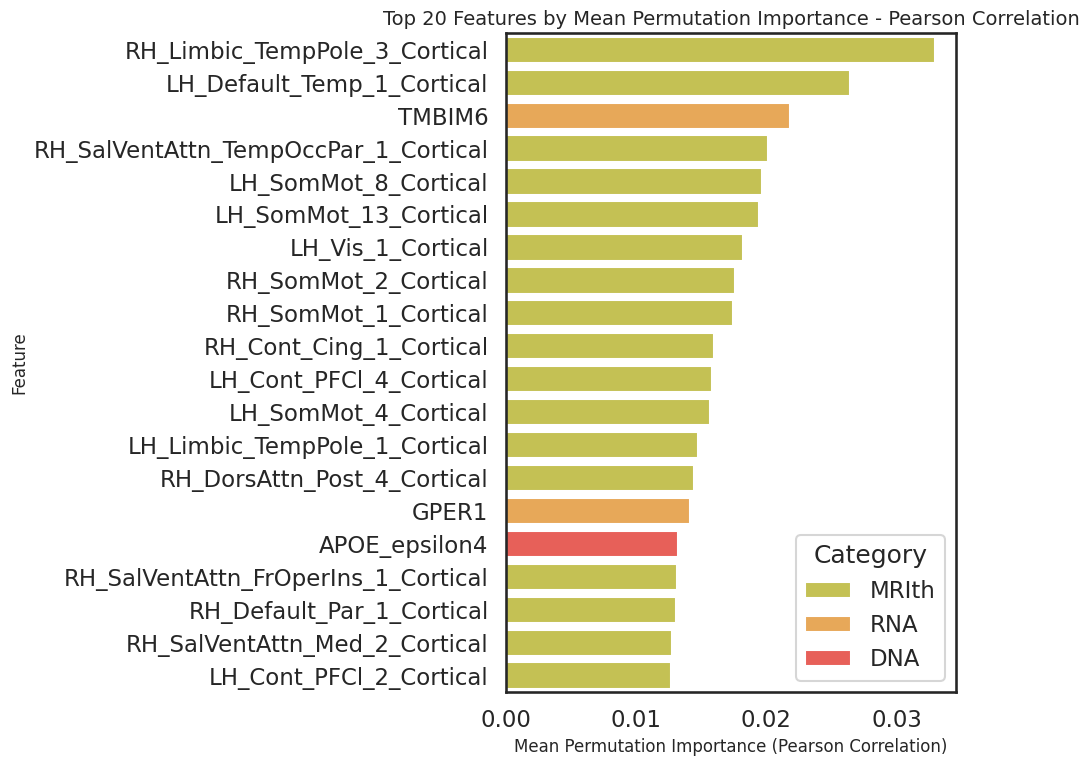

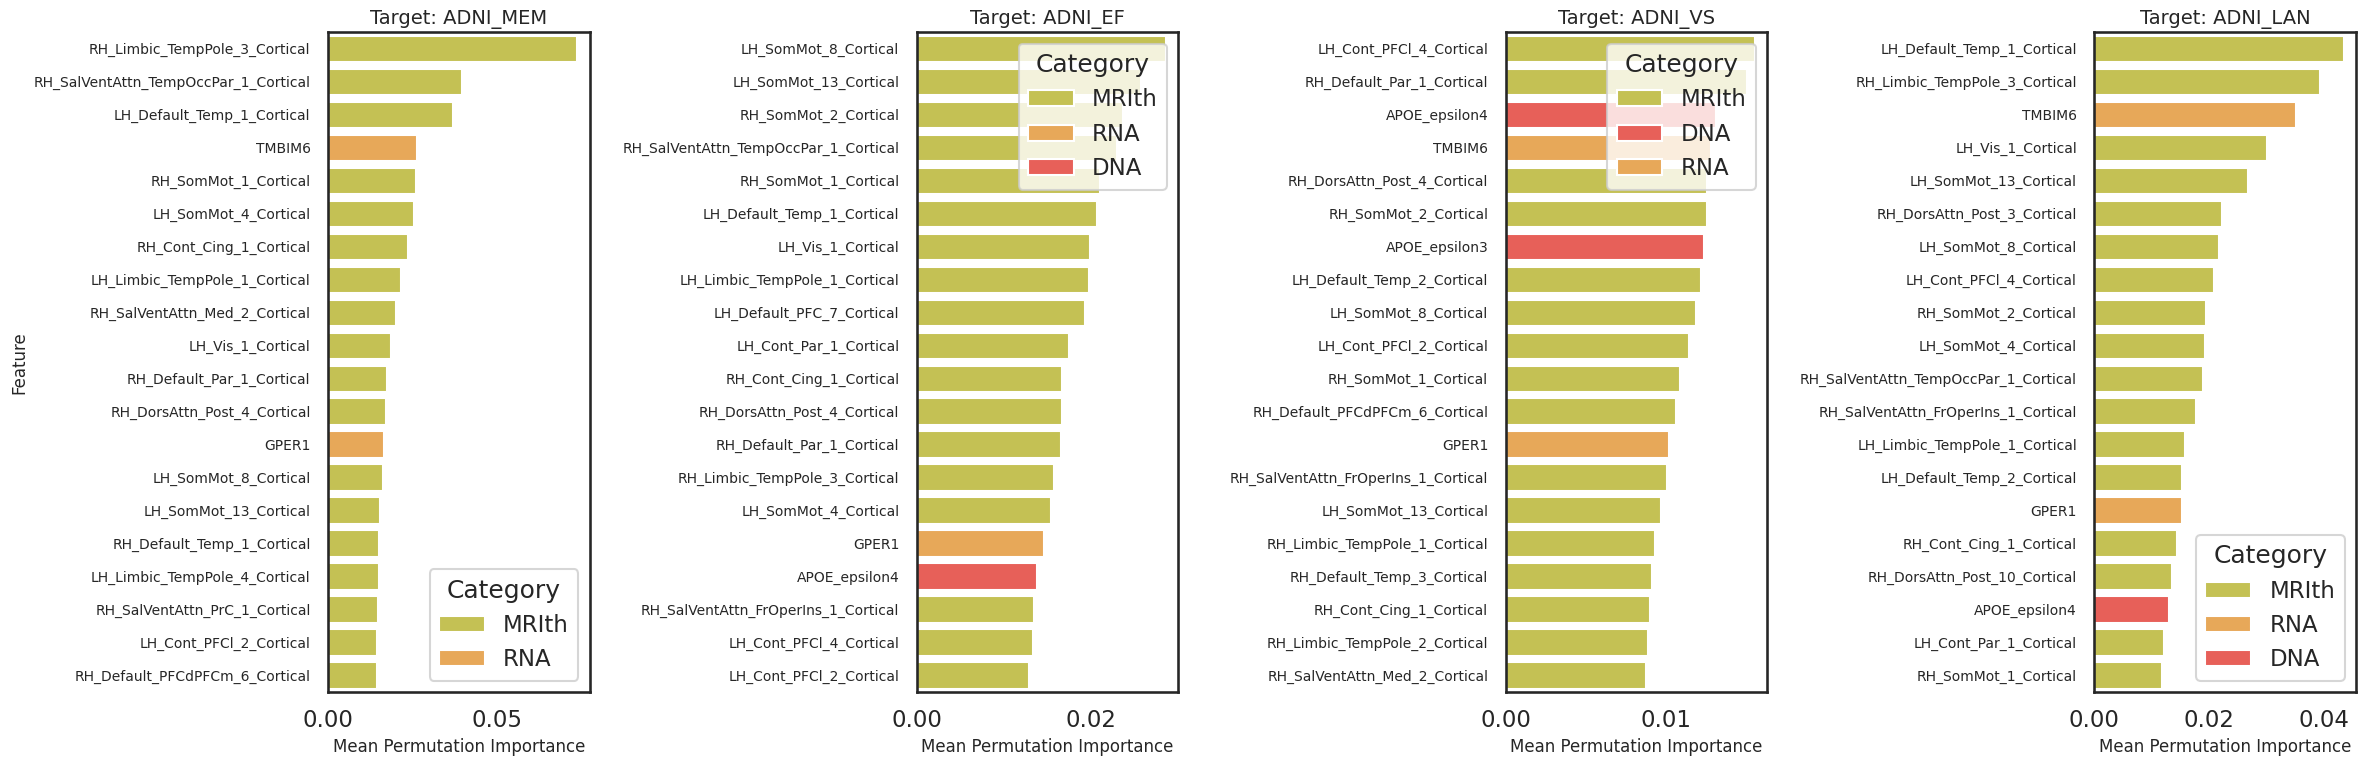

In [48]:
random_idx = random.sample(X_train_adjusted.index.tolist(), k=200)

X_test = X_train_adjusted.loc[random_idx]
Y_test = y_train_adjusted.loc[random_idx]

model = tabnet_model

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=mae_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)

# Add a 'Category' column based on the 'select' dictionary
mean_importance['Category'] = mean_importance['Feature'].map(
    lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
)

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance - Pearson Correlation", top_n=n_features, hue="Category", palette=category_palette)

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)

    importances['Category'] = importances['Feature'].map(
    lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette=category_palette, hue="Category", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

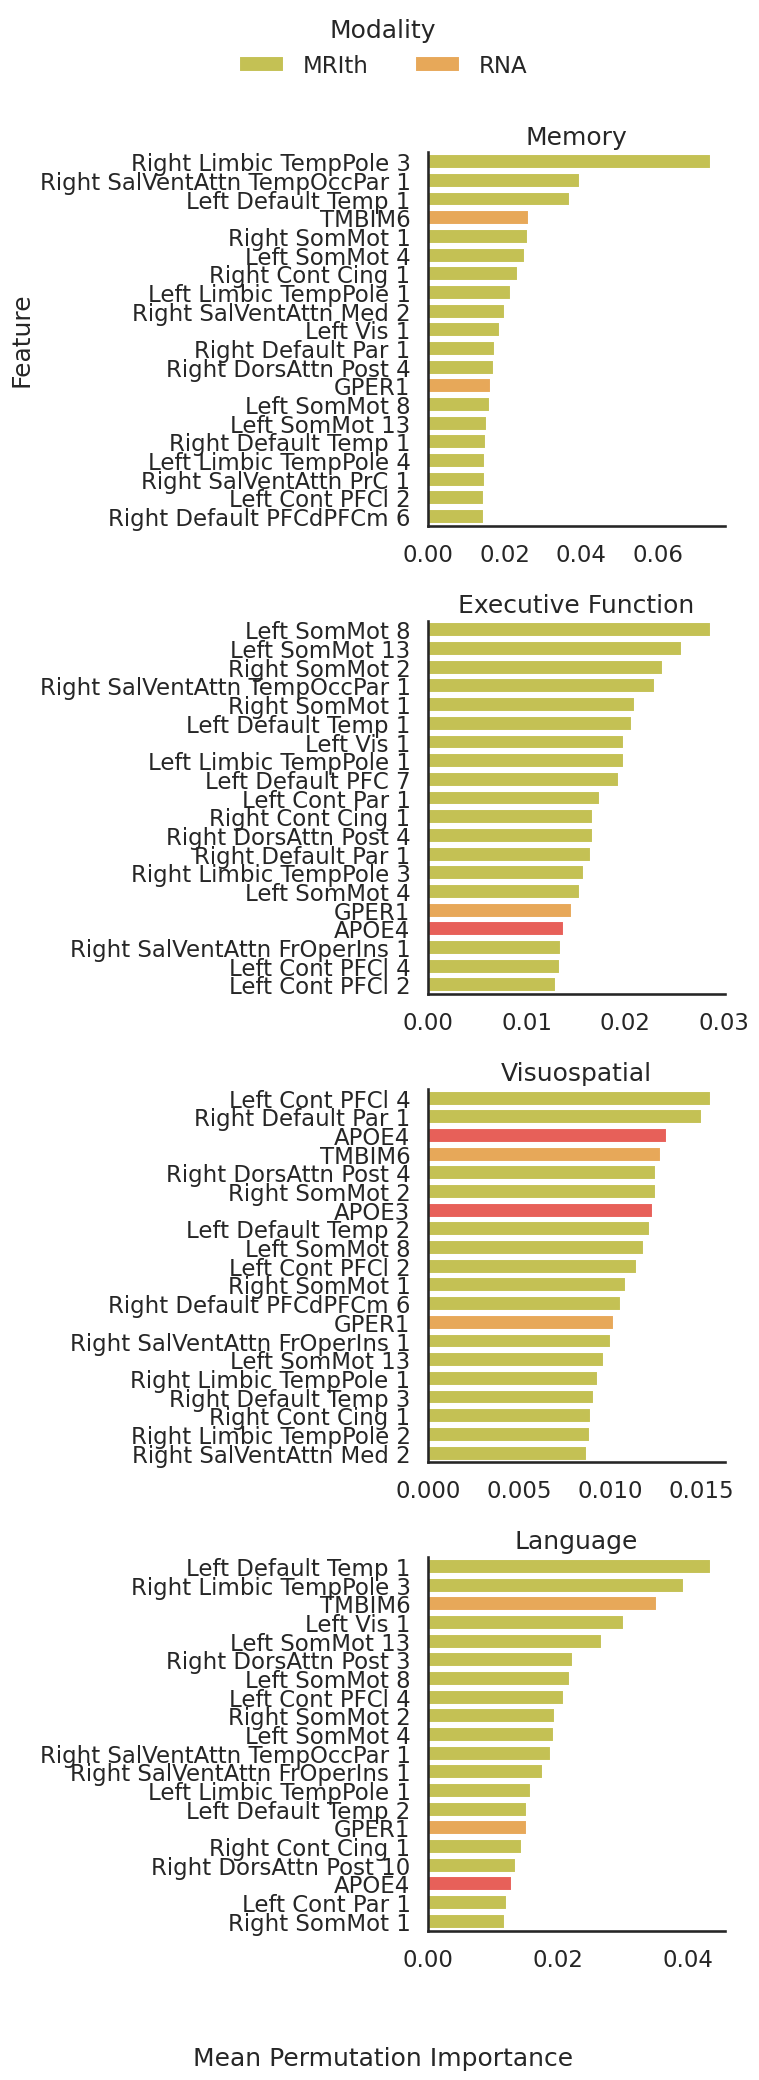

In [49]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(num_targets, 1, figsize=(8, 5 * num_targets), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top n features for the current target
    importances = permutation_results[target].head(n_features)
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
    )
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax,
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)
    
    # Title and labels
    readable_title = readable_names.get(target, target)  # Use readable name or fallback to original
    ax.set_title(readable_title, fontsize=18)
    
    ax.set_xlabel("")  # Remove individual x-labels
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature")
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y')

    ax.legend().set_visible(False)

# Remove duplicate legends and create a single, consistent legend
handles, labels = axes[0].get_legend_handles_labels()
unique_handles_labels = list(zip(handles, labels))
handles, labels = zip(*sorted(unique_handles_labels, key=lambda x: x[1]))  # Sort legend alphabetically

fig.legend(
    handles, labels, title="Modality", loc="upper center", bbox_to_anchor=(0.5, 1.05),
    ncol=3, frameon=False
)

# Add a single x-label in the bottom-middle of the figure
fig.text(0.5, 0.02, "Mean Permutation Importance", ha="center", va="center", fontsize=18)

sns.despine()

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the x-label
plt.show()


#### Shapeley values

In [50]:
X_test = X_test_adjusted
Y_test = y_test_adjusted

# Step 1: Initialize the SHAP Explainer and Compute SHAP Values
explainer = shap.KernelExplainer(model.model.predict, X_test)
shap_values = explainer(X_test)  # SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

  0%|          | 0/13 [00:00<?, ?it/s]

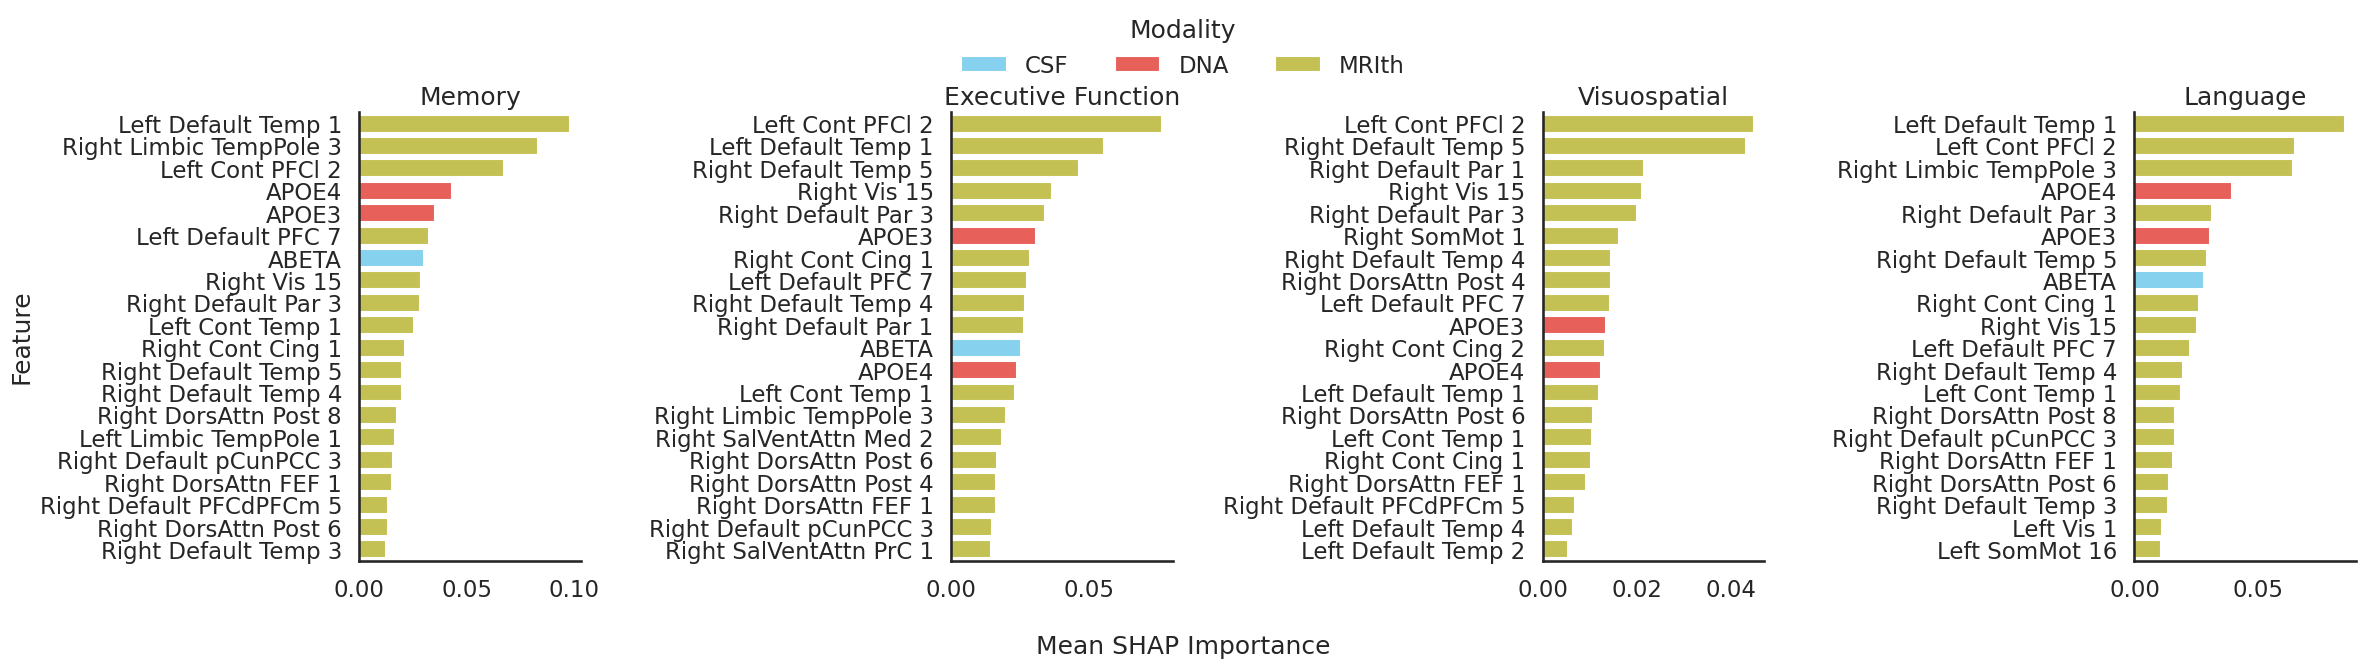

In [51]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 6), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(shap_results.keys(), axes)):
    # Select the top n features for the current target
    importances = shap_results[target].head(n_features)
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 'Unknown')
    )
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax,
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)
    
    # Title and labels
    readable_title = readable_names.get(target, target)  # Use readable name or fallback to original
    ax.set_title(readable_title, fontsize=18)
    
    ax.set_xlabel("")  # Remove individual x-labels
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature")
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y')

    ax.legend().set_visible(False)

# Remove duplicate legends and create a single, consistent legend
handles, labels = axes[0].get_legend_handles_labels()
unique_handles_labels = list(zip(handles, labels))
handles, labels = zip(*sorted(unique_handles_labels, key=lambda x: x[1]))  # Sort legend alphabetically

fig.legend(
    handles, labels, title="Modality", loc="upper center", bbox_to_anchor=(0.5, 1.1),
    ncol=3, frameon=False
)

# Add a single x-label in the bottom-middle of the figure
fig.text(0.5, 0.02, "Mean SHAP Importance", ha="center", va="center", fontsize=18)

sns.despine()

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the x-label
plt.show()


['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

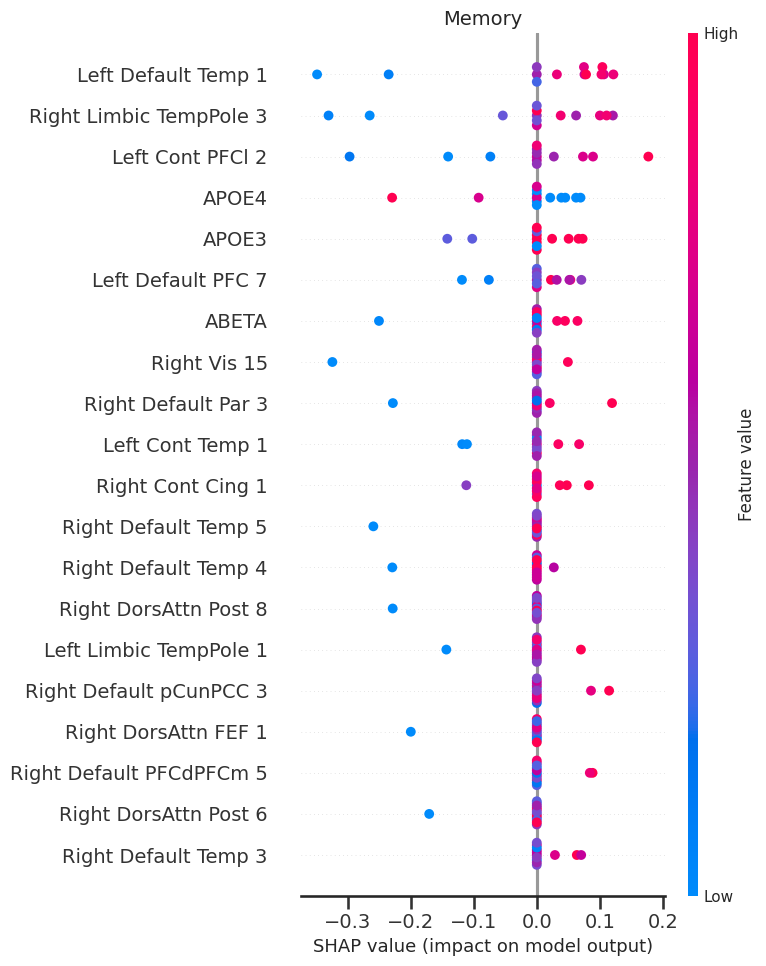

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

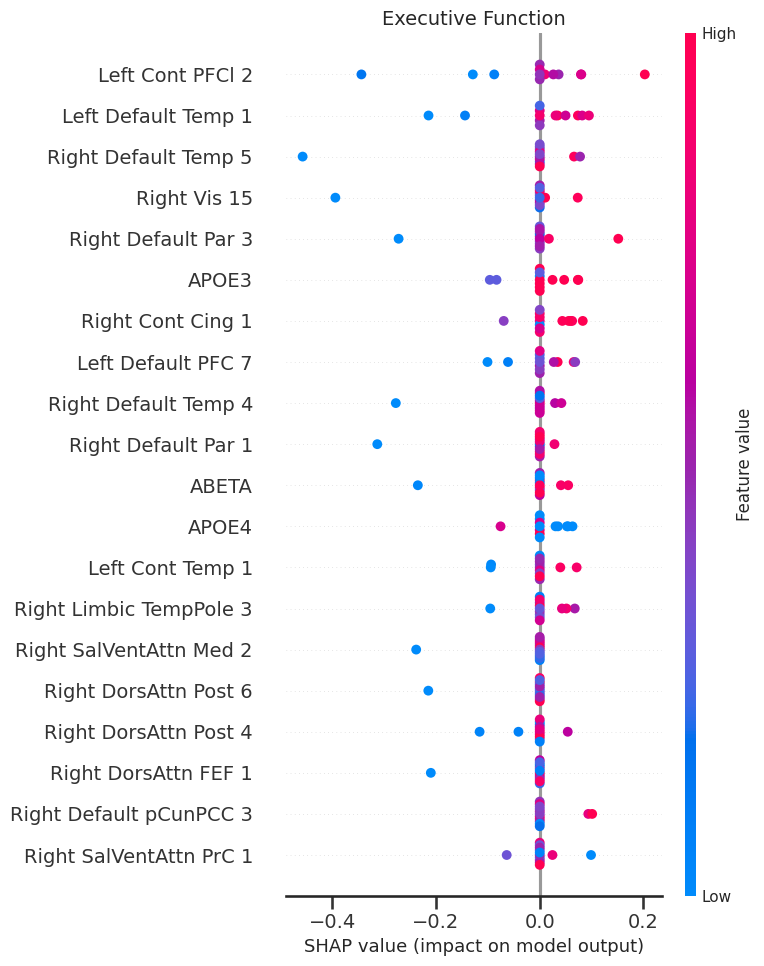

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

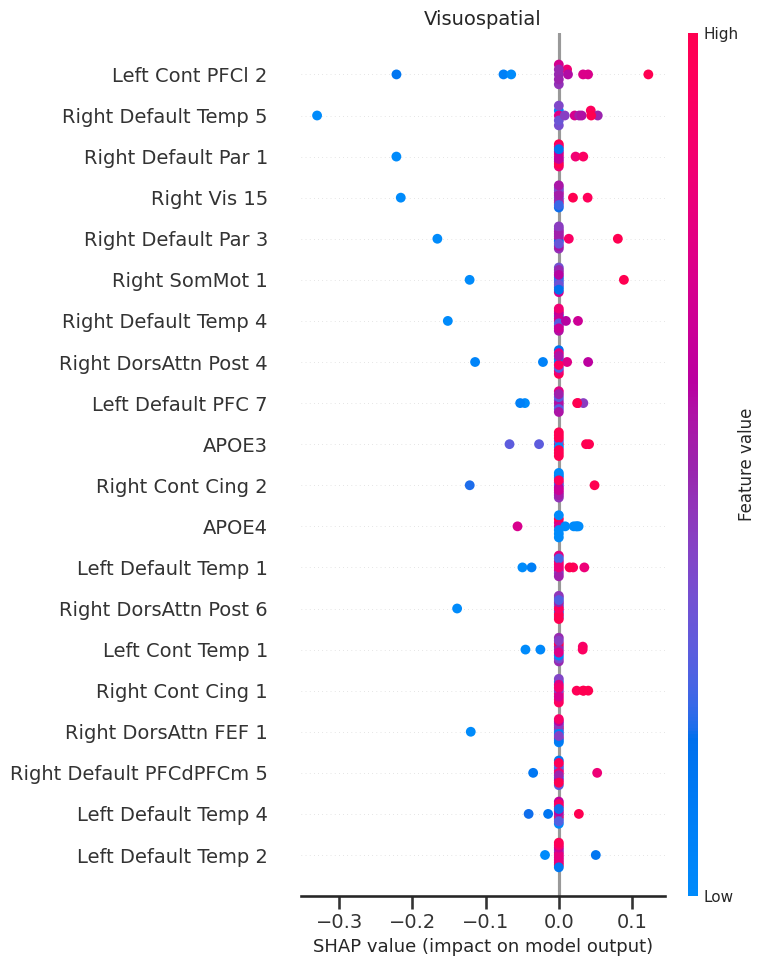

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

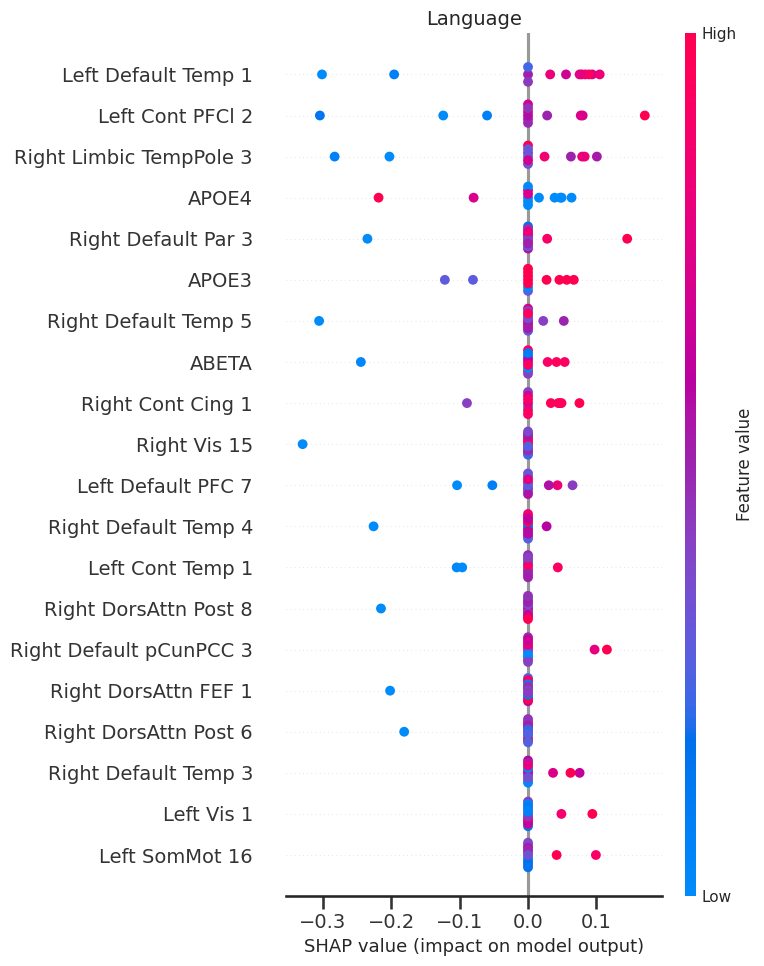

In [52]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Clean feature names for readability
def clean_feature_names(features):
    return [clean_ytick_label(feature) for feature in features]

# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    # Get the readable target name
    readable_title = readable_names.get(target, target)  # Default to the original name if not found

    # Clean feature names
    clean_names = clean_feature_names(X_test.columns)
    print(f"{clean_names}")
    
    # Generate SHAP summary plot
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test,
        feature_names=clean_names,  # Use cleaned feature names
        max_display=n_features,
        show=False  # Do not show the plot immediately
    )
    
    # Access the current figure and axes
    fig = plt.gcf()
    ax = plt.gca()
    
    # Adjust the figure size
    fig.set_size_inches(8, 10)  # Example size: 8x6 inches
    
    # Increase marker size
    for collection in ax.collections:
        if hasattr(collection, "set_sizes"):  # Check if it's a scatter plot
            collection.set_sizes([50])  # Set marker size (adjust as needed)
    
    # Set the readable title for the current target
    ax.set_title(readable_title, fontsize=14)  # Example: set the title size
    
    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=14)  
    
    # Show the modified plot
    plt.tight_layout()
    plt.show()


##### Same but on X_train

In [53]:
random_idx = random.sample(X_train_adjusted.index.tolist(), k=100)

X_test = X_train_adjusted.loc[random_idx]
Y_test = y_train_adjusted.loc[random_idx]

# Step 1: Initialize the SHAP Explainer and Compute SHAP Values
explainer = shap.KernelExplainer(model.model.predict, X_test)
shap_values = explainer(X_test)  # SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

  0%|          | 0/100 [00:00<?, ?it/s]

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

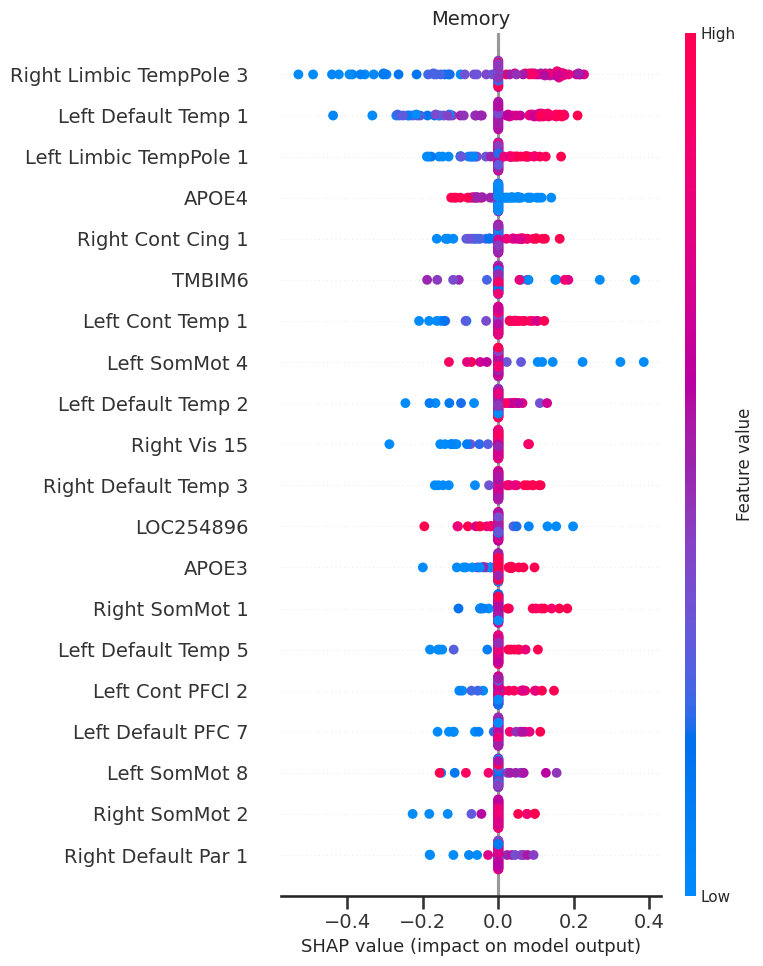

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

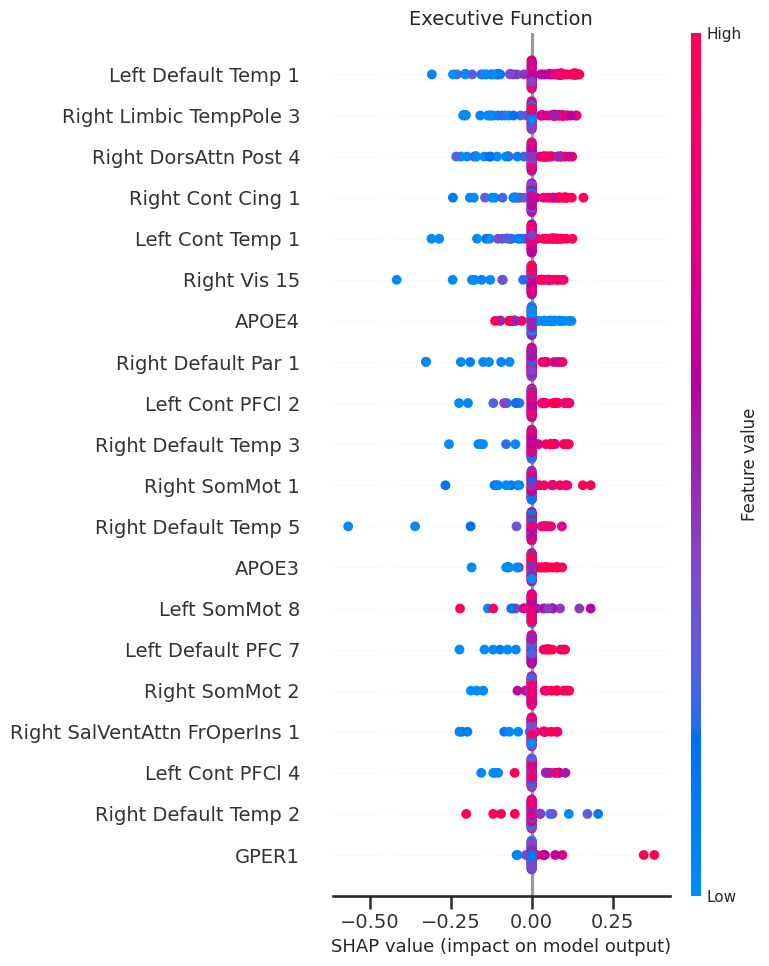

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

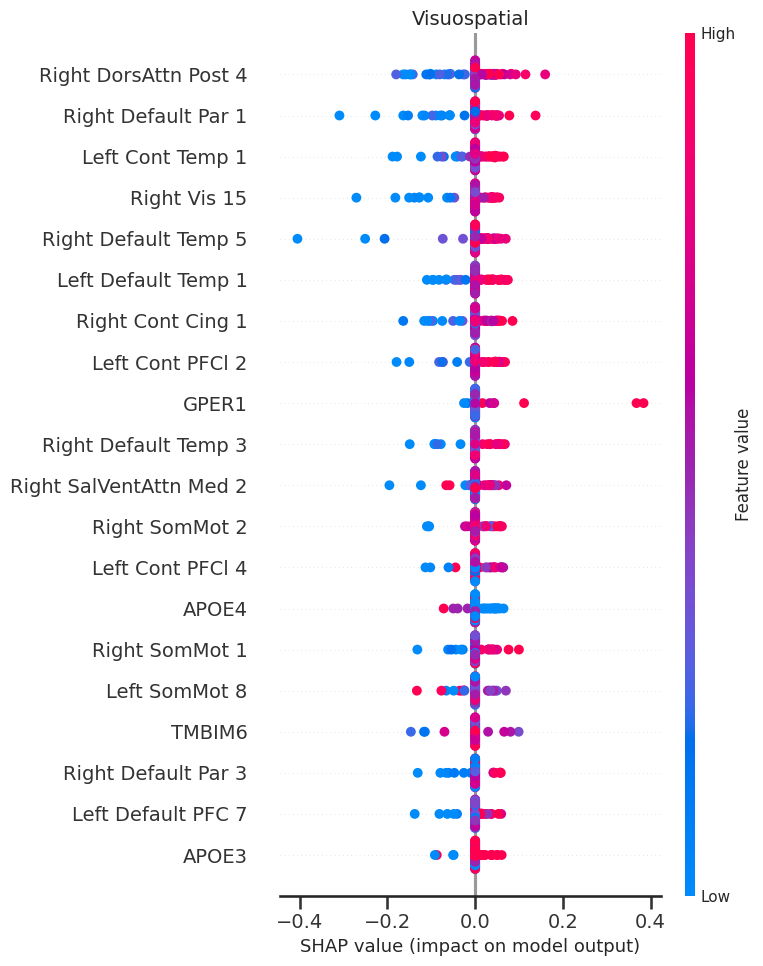

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

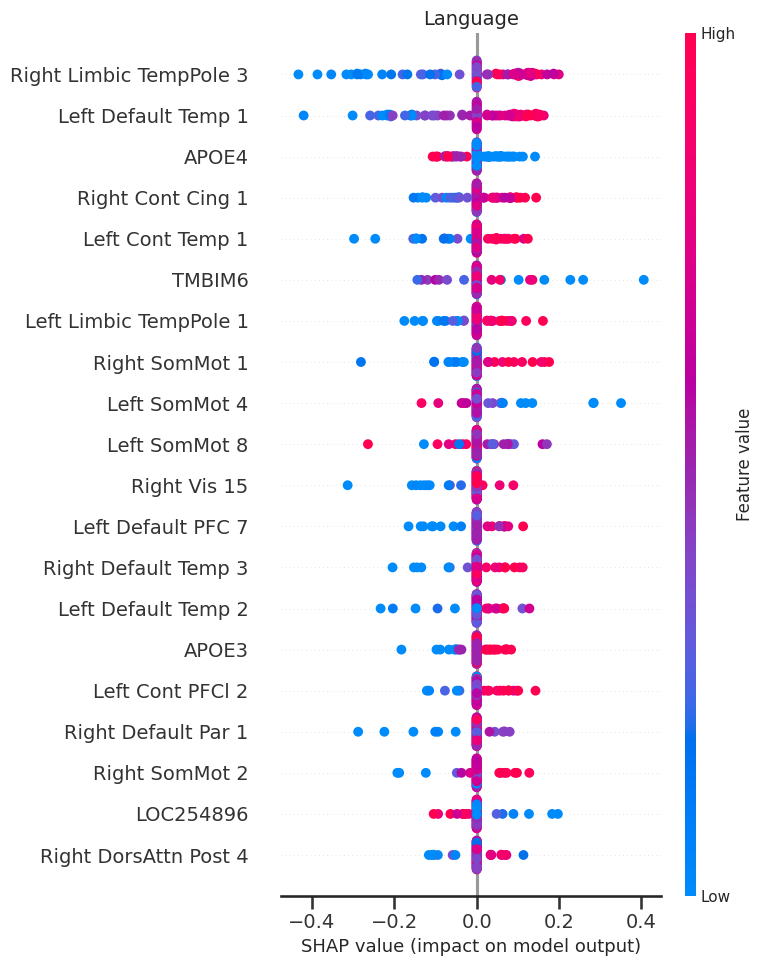

In [54]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Clean feature names for readability
def clean_feature_names(features):
    return [clean_ytick_label(feature) for feature in features]

# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    # Get the readable target name
    readable_title = readable_names.get(target, target)  # Default to the original name if not found

    # Clean feature names
    clean_names = clean_feature_names(X_test.columns)
    print(f"{clean_names}")
    
    # Generate SHAP summary plot
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test,
        feature_names=clean_names,  # Use cleaned feature names
        max_display=n_features,
        show=False  # Do not show the plot immediately
    )
    
    # Access the current figure and axes
    fig = plt.gcf()
    ax = plt.gca()
    
    # Adjust the figure size
    fig.set_size_inches(8, 10)  # Example size: 8x6 inches
    
    # Increase marker size
    for collection in ax.collections:
        if hasattr(collection, "set_sizes"):  # Check if it's a scatter plot
            collection.set_sizes([50])  # Set marker size (adjust as needed)
    
    # Set the readable title for the current target
    ax.set_title(readable_title, fontsize=14)  # Example: set the title size
    
    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=14)  
    
    # Show the modified plot
    plt.tight_layout()
    plt.show()


#### Save to csv for MATLAB

In [55]:
permutation_results["ADNI_MEM"].head(20)

Feature  Importance
183         RH_Limbic_TempPole_3_Cortical    0.073785
151  RH_SalVentAttn_TempOccPar_1_Cortical    0.039589
202            LH_Default_Temp_1_Cortical    0.037091
13                                 TMBIM6    0.026331
87                   RH_SomMot_1_Cortical    0.026203
90                   LH_SomMot_4_Cortical    0.025362
211               RH_Cont_Cing_1_Cortical    0.023579
168         LH_Limbic_TempPole_1_Cortical    0.021764
169         RH_SalVentAttn_Med_2_Cortical    0.020209
56                      LH_Vis_1_Cortical    0.018778
219             RH_Default_Par_1_Cortical    0.017604
131           RH_DorsAttn_Post_4_Cortical    0.017265
28                                  GPER1    0.016532
98                   LH_SomMot_8_Cortical    0.016213
108                 LH_SomMot_13_Cortical    0.015475
225            RH_Default_Temp_1_Cortical    0.015097
174         LH_Limbic_TempPole_4_Cortical    0.014991
157         RH_SalVentAttn_PrC_1_Cortical    0.014797
188               LH_Cont_PFCl_2_Cortical    0.014633
247        RH_Default_PFCdPFCm_6_Cortical    0.014519

In [56]:
def extract_features_to_matrix(permutation_results, select_key, select_features):
    """
    Extract specific features from DataFrames in a dictionary and stitch them into a matrix.
    
    Args:
    - permutation_results (dict): Dictionary with keys (e.g., ['ADNI_MEM', 'ADNI_EF', ...])
                                  and values as DataFrames with 'Feature' and 'Importance' columns.
    - select_key (str): The key in the `select` dictionary to extract features from.
    - select_features (pd.Index or list): List or Index of features to extract.

    Returns:
    - pd.DataFrame: A matrix (DataFrame) where rows are features and columns are the keys from `permutation_results`.
    """
    # Initialize an empty dictionary to store extracted features
    extracted_data = {}
    
    for key, df in permutation_results.items():
        # Filter the DataFrame to include only the selected features in the specified order
        filtered_df = df[df['Feature'].isin(select_features)]
        # Reindex to ensure the features are in the same order as select_features
        reindexed_df = filtered_df.set_index('Feature').reindex(select_features)
        # Extract the Importance values
        extracted_data[key] = reindexed_df['Importance'].values
    
    # Combine the extracted Importance values into a single DataFrame
    combined_matrix = pd.DataFrame(extracted_data, index=select_features)
    
    return combined_matrix

In [57]:
permutation_matrix = extract_features_to_matrix(permutation_results, 'MRIth', select_MRIthickness)
permutation_matrix.to_csv('../pickle/TabNet_permutation_mae_MRI.csv', index=False, header=False)

In [58]:
shap_results.keys()

dict_keys(['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'])

In [59]:
shap_matrix = extract_features_to_matrix(shap_results, 'MRIth', select_MRIthickness)
shap_matrix.to_csv('../pickle/TabNet_shap_train_MRI.csv', index=False, header=False)

In [60]:
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

def compute_agreement(matrix1, matrix2, top_k=20):
    # Ensure inputs are numpy arrays
    matrix1, matrix2 = np.array(matrix1), np.array(matrix2)
    
    # Rank correlation (average across columns)
    rank_correlation = np.mean([
        spearmanr(matrix1[:, i], matrix2[:, i]).correlation for i in range(matrix1.shape[1])
    ])
    
    # Cosine similarity (average across rows)
    row_cosine_similarity = np.mean(cosine_similarity(matrix1, matrix2))
    
    # Top-k feature overlap (Jaccard index)
    top_features1 = set(np.argsort(matrix1.mean(axis=1))[-top_k:])
    top_features2 = set(np.argsort(matrix2.mean(axis=1))[-top_k:])
    top_overlap = len(top_features1 & top_features2) / len(top_features1 | top_features2)
    
    # Element-wise agreement (MSE)
    mse_error = mean_squared_error(matrix1, matrix2)
    
    # Composite metric
    alpha1, alpha2, alpha3, alpha4 = 1, 1, 1, 1
    agreement_score = (
        alpha1 * rank_correlation +
        alpha2 * row_cosine_similarity +
        alpha3 * top_overlap -
        alpha4 * mse_error
    )
    
    return {
        "RankCorrelation": rank_correlation,
        "CosineSimilarity": row_cosine_similarity,
        "TopFeatureOverlap": top_overlap,
        "MSE": mse_error,
        "AgreementScore": agreement_score
    }

# Example Usage
# Assuming `perm_matrix` and `shap_matrix` are your two matrices
agreement_metrics = compute_agreement(permutation_matrix, shap_matrix)
print(agreement_metrics)


{'RankCorrelation': 0.5259446896008254, 'CosineSimilarity': 0.4438120525201573, 'TopFeatureOverlap': 0.5384615384615384, 'MSE': 4.339158162565915e-05, 'AgreementScore': 1.5081748890008955}


In [61]:
agree_matrix = permutation_matrix * shap_matrix
agree_matrix.to_csv('../pickle/TabNet_agree_MRI.csv', index=False, header=False)

In [62]:
local_importance = tabnet_model.model.feature_importances_
local_importance = local_importance[df_X.columns.isin(select_MRIthickness)]

In [63]:
pd.DataFrame(local_importance).to_csv('../pickle/TabNet_local_MRI.csv', index=False, header=False)

#### Owen values

In [64]:
model = tabnet_model

X_test = X_test_adjusted
Y_test = y_test_adjusted

# build a clustering of the features based on shared information about y
Y_train = y_train_adjusted
clustering = shap.utils.hclust(X_test)

# above we implicitly used shap.maskers.Independent by passing a raw dataframe as the masker
# now we explicitly use a Partition masker that uses the clustering we just computed
masker = shap.maskers.Partition(X_test, clustering=clustering)

# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.PartitionExplainer(model.model.predict, X_test)
shap_values2 = explainer(X_test)

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

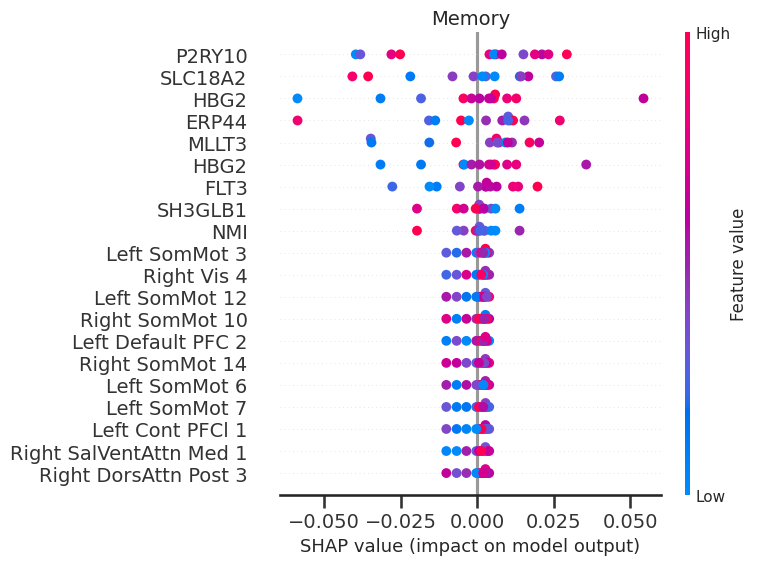

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

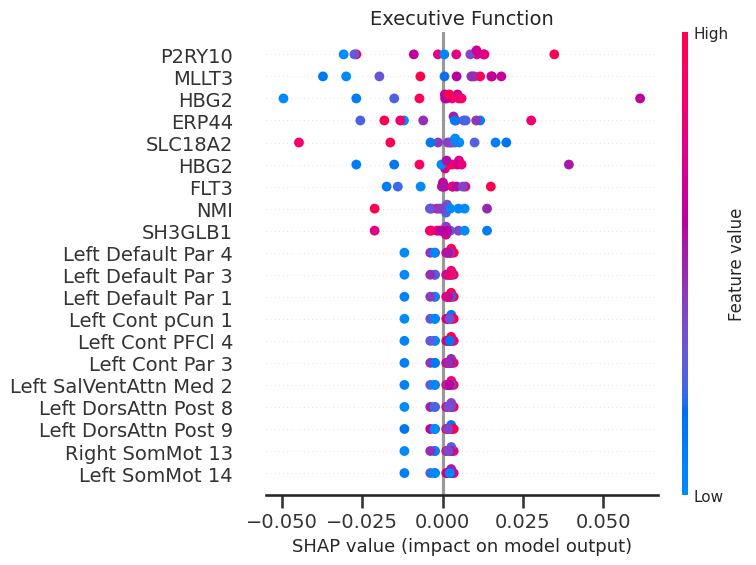

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

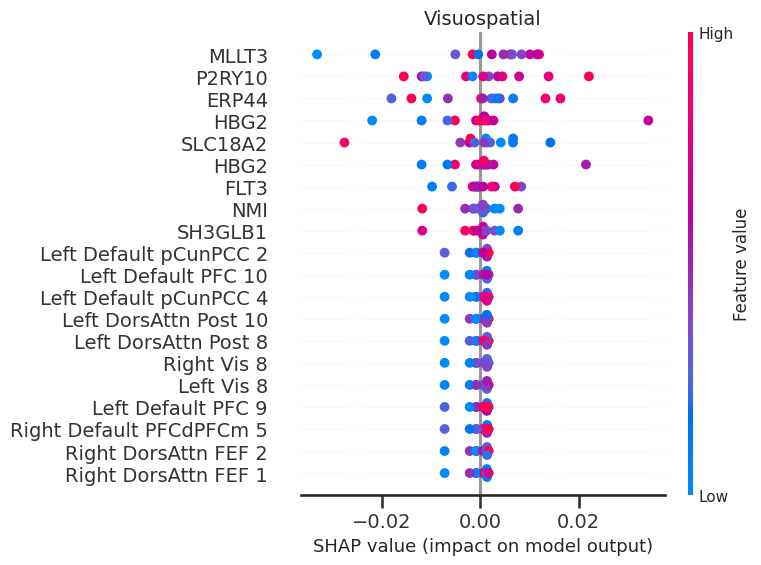

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

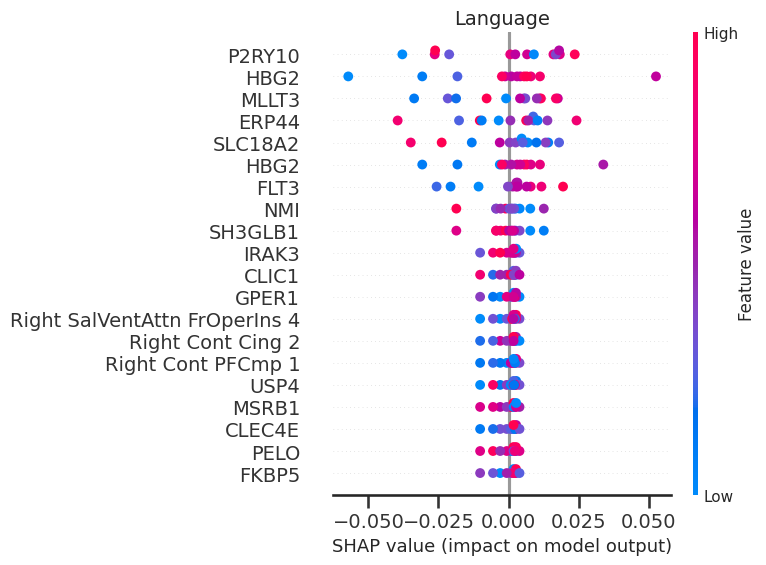

In [65]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Clean feature names for readability
def clean_feature_names(features):
    return [clean_ytick_label(feature) for feature in features]

# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    # Get the readable target name
    readable_title = readable_names.get(target, target)  # Default to the original name if not found

    # Clean feature names
    clean_names = clean_feature_names(X_test.columns)
    print(f"{clean_names}")
    
    # Generate SHAP summary plot
    shap.summary_plot(
        shap_values2.values[:, :, i],
        X_test,
        feature_names=clean_names,  # Use cleaned feature names
        max_display=n_features,
        show=False  # Do not show the plot immediately
    )
    
    # Access the current figure and axes
    fig = plt.gcf()
    ax = plt.gca()
    
    # Adjust the figure size
    fig.set_size_inches(8, 6)  # Example size: 8x6 inches
    
    # Increase marker size
    for collection in ax.collections:
        if hasattr(collection, "set_sizes"):  # Check if it's a scatter plot
            collection.set_sizes([50])  # Set marker size (adjust as needed)
    
    # Set the readable title for the current target
    ax.set_title(readable_title, fontsize=14)  # Example: set the title size
    
    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=14)  
    
    # Show the modified plot
    plt.tight_layout()
    plt.show()


#### Owen values on X_train subset

In [66]:
model = tabnet_model

random_idx = random.sample(X_train_adjusted.index.tolist(), k=200)

X_test = X_train_adjusted.loc[random_idx]
Y_test = y_train_adjusted.loc[random_idx]

# build a clustering of the features based on shared information about y
Y_train = y_train_adjusted
clustering = shap.utils.hclust(X_test)

# above we implicitly used shap.maskers.Independent by passing a raw dataframe as the masker
# now we explicitly use a Partition masker that uses the clustering we just computed
masker = shap.maskers.Partition(X_test, clustering=clustering)

# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.PartitionExplainer(model.model.predict, X_test)
shap_values2 = explainer(X_test)

PartitionExplainer explainer: 201it [01:39,  1.81it/s]                         


In [67]:
# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values2.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

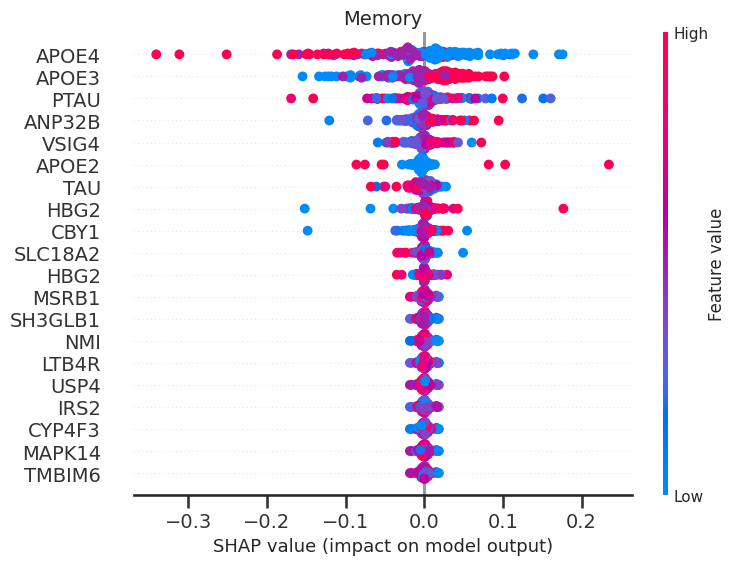

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

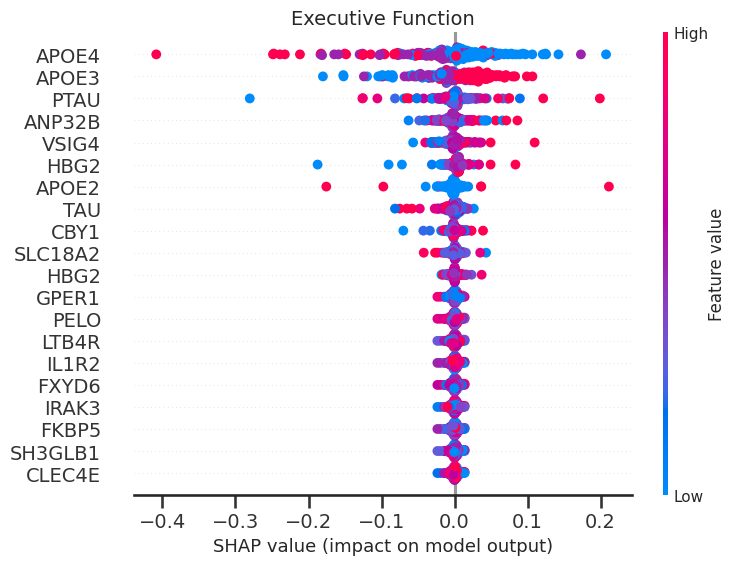

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

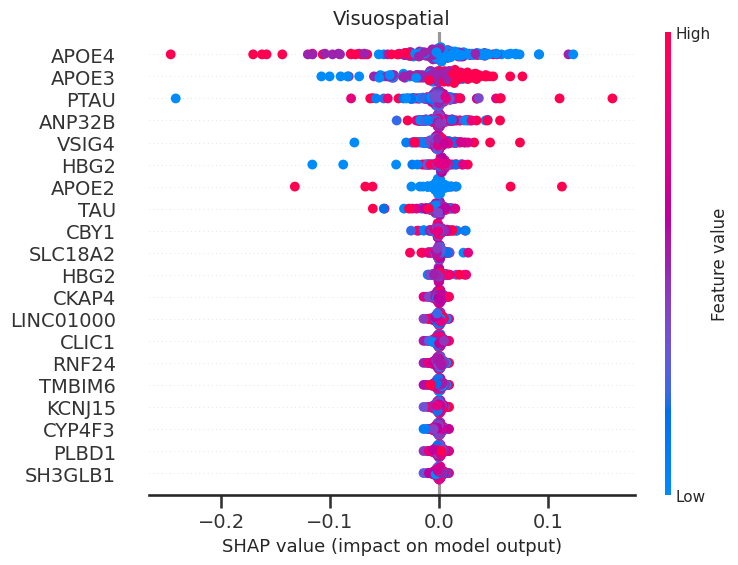

['LRRK2', 'MAPK14', 'ERP44', 'LOC254896', 'CREBRF', 'HBG2', 'IRS2', 'CYP4F3', 'CD63', 'LINC01000', 'SLC18A2', 'RNF24', 'ZNF438', 'TMBIM6', 'KCNJ15', 'MS4A1', 'NMI', 'MLLT3', 'USP4', 'CBY1', 'MSRB1', 'FKBP5', 'FXYD6', 'IL1R2', 'LTB4R', 'VSIG4', 'TCL1A', 'PELO', 'GPER1', 'IRAK3', 'HBG2', 'SH3GLB1', 'CLIC1', 'CLEC4E', 'PLBD1', 'ANP32B', 'FLT3', 'ENTPD1', 'P2RY10', 'CKAP4', 'ANXA3', 'CREB5', 'LTBR', 'CEBPD', 'GCM1', 'SLC26A8', 'QPCT', 'PIK3C2B', 'PYGL', 'NSMAF', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1', 'Right Vis 15', 'Left SomMot 2', 'Right SomMot 1', 'L

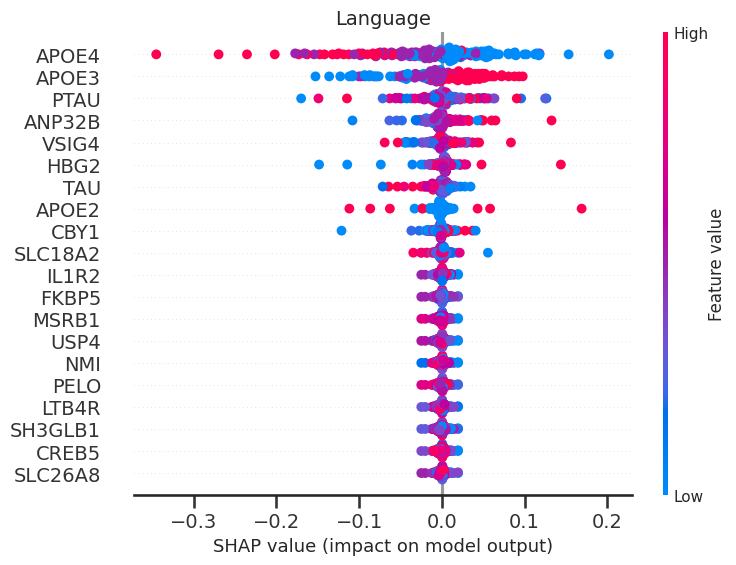

In [68]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Clean feature names for readability
def clean_feature_names(features):
    return [clean_ytick_label(feature) for feature in features]

# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    # Get the readable target name
    readable_title = readable_names.get(target, target)  # Default to the original name if not found

    # Clean feature names
    clean_names = clean_feature_names(X_test.columns)
    print(f"{clean_names}")
    
    # Generate SHAP summary plot
    shap.summary_plot(
        shap_values2.values[:, :, i],
        X_test,
        feature_names=clean_names,  # Use cleaned feature names
        max_display=n_features,
        show=False  # Do not show the plot immediately
    )
    
    # Access the current figure and axes
    fig = plt.gcf()
    ax = plt.gca()
    
    # Adjust the figure size
    fig.set_size_inches(8, 6)  # Example size: 8x6 inches
    
    # Increase marker size
    for collection in ax.collections:
        if hasattr(collection, "set_sizes"):  # Check if it's a scatter plot
            collection.set_sizes([50])  # Set marker size (adjust as needed)
    
    # Set the readable title for the current target
    ax.set_title(readable_title, fontsize=14)  # Example: set the title size
    
    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=14)  
    
    # Show the modified plot
    plt.tight_layout()
    plt.show()


In [69]:
owen_matrix = extract_features_to_matrix(shap_results, 'MRIth', select_MRIthickness)
owen_matrix.to_csv('../pickle/TabNet_owen_train_MRI.csv', index=False, header=False)